# 01 - Uploading, Reading, & Preprocessing Image Data

### 1. Imports

In [288]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# os & image imports
import os
from PIL import Image

# keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall, SpecificityAtSensitivity, SensitivityAtSpecificity

To read the data in and also store the labels, I am going to make a dataframe by iterating through the contents of the `archive` folder under the `data` directory. Each images are further split into `Testing` and `Training` folders, each with separate directories for images corresponding to the type of tumor: Glioma, Meningioma, Pituitary, No Tumor.

In [11]:
# define paths to test & train directories
test_directory = './data/archive/Testing'
train_directory = './data/archive/Training'

### 2. Manual Preprocessing

In [167]:
def image_to_df(filepath):
    
    base = os.listdir(filepath)
    base.remove('.DS_Store') # removes this element from the list, remaining should be the actual folders
    
    X = []
    y = []
    img_path = []
    folder_path = []
    
    for folder_name in base:
        images = os.listdir(filepath + f'/{folder_name}')
        for i in images:
            if i.endswith(".jpg"):
                image = Image.open(f'{filepath}/{folder_name}/{i}') # open the image
                image = image.resize((256,256)) # resize to 256x256
                image = image.convert('L') # convert all to grayscale
                image = np.array(image) / 255. # turn image into an array of matrices & rescale!
                X.append(image)
                y.append(folder_name)
                img_path.append(f'{filepath}/{folder_name}/{i}')
                folder_path.append(f'{filepath}/{folder_name}')
            
    return pd.DataFrame(data={'folder_path': folder_path,'img_path': img_path, 'image_data': X, 'label': y})

In [168]:
# storing the output of the function for test data
test_df = image_to_df(test_directory)

In [169]:
# storing the output of the function for train data
train_df = image_to_df(train_directory)

In [170]:
test_df.head()

,folder_path,img_path,image_data,label
0,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0233.jpg,"[[0.0, 0.0, 0.0, 0.00392156862745098, 0.0, 0.0...",pituitary
1,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0227.jpg,"[[0.00392156862745098, 0.00392156862745098, 0....",pituitary
2,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0019.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",pituitary
3,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0031.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",pituitary
4,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0025.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",pituitary


In [171]:
train_df.head()

,folder_path,img_path,image_data,label
0,./data/archive/Training/pituitary,./data/archive/Training/pituitary/Tr-pi_0505.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",pituitary
1,./data/archive/Training/pituitary,./data/archive/Training/pituitary/Tr-pi_0263.jpg,"[[0.00392156862745098, 0.00392156862745098, 0....",pituitary
2,./data/archive/Training/pituitary,./data/archive/Training/pituitary/Tr-pi_0277.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",pituitary
3,./data/archive/Training/pituitary,./data/archive/Training/pituitary/Tr-pi_1169.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",pituitary
4,./data/archive/Training/pituitary,./data/archive/Training/pituitary/Tr-pi_0511.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...",pituitary


In [184]:
print(f'Images in Training across all 4 classes: {len(train_df)}')
print("===============================================")
print(f'Images in Testing across all 4 classes: {len(test_df)}')

Images in Training across all 4 classes: 5712
Images in Testing across all 4 classes: 1311


In [185]:
print(f'Testing image array: {test_df.iloc[0,2].shape}')
print(f'Training image array: {train_df.iloc[0,2].shape}')
print("===============================================")
print('256 x 256 is expected since I resized the images in my above function.')

Testing image array: (256, 256)
Training image array: (256, 256)
256 x 256 is expected since I resized the images in my above function.


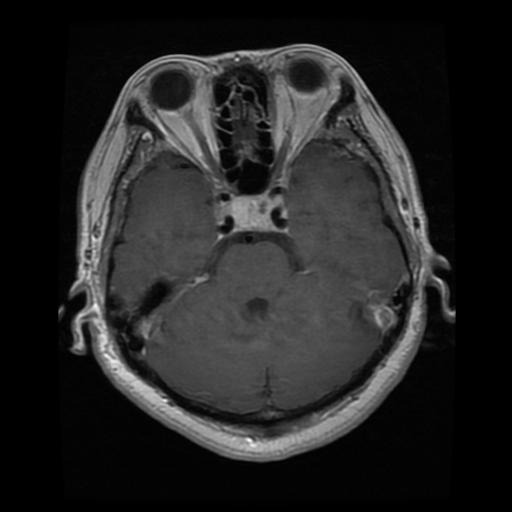

In [175]:
Image.open(train_df.iloc[0,1])

In [176]:
#### EDA CAN BE PERFORMED HERE ON THE CLASS LABELS AND PORTION OF EACH CLASS (or in a separate jpynb)

At this point, I had a training and testing dataframe that consisted of a filepath, array data, and class label for each image. The array data was extracted from the function I wrote to put the dataframes together which included the preprocessing workflows (resizing, rescaling, and converting images to 'L' (grayscale). However, I realized after this point that there is more preprocessing I can do, and I was recommneded by the TA to try using `ImageDataGenerator` from `keras`. So, I will work through the preprocessing workflow again using the filepaths I already have in my dataframe, but this time I will try to do it via `ImageDataGenerator`. This will also allow me to do things like include batches of images to feed into my model and augment the data, which may help improve model performance.

### 3. Preprocessing with `ImageDataGenerator()`

In [236]:
# instantiate ImageDataGenerator Class (called 'idg')
idg_train = ImageDataGenerator(horizontal_flip = True,
                        rescale = 1./255,)


# keep testing separate to prevent data leakage
idg_test = ImageDataGenerator(rescale = 1./255) 

**1. Training Data Generator**

In [237]:
train_data_gen = idg_train.flow_from_dataframe(train_df, 
                             x_col = 'img_path', 
                             y_col = 'label',
                             class_mode = 'categorical',
                             target_size = (256,256),
                             batch_size = 32,
                             color_mode = 'grayscale',
                             classes = {'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}) # setting the default class indices

Found 5712 validated image filenames belonging to 4 classes.


In [238]:
# dictionary - numerical representations for each categorical var
train_data_gen.class_indices

{'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}

**2. Testing Data Generator**

In [239]:
test_data_gen = idg_test.flow_from_dataframe(test_df, 
                             x_col = 'img_path', 
                             y_col = 'label',
                             class_mode = 'categorical',
                             target_size = (256,256),
                             batch_size = 32,
                             color_mode = 'grayscale',
                             classes = {'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}) # setting the default class indices

Found 1311 validated image filenames belonging to 4 classes.


In [240]:
# ensure labels are presented the same as train
test_data_gen.class_indices

{'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}

In [241]:
print(train_data_gen.image_shape)
print(test_data_gen.image_shape)

# this is accurate (256x256 size) and 1 for the channel (black/white)

(256, 256, 1)
(256, 256, 1)


### 4. Building the First Model

In [315]:
# instantiating Sequential model, 'model_1'
model_1 = Sequential()

# layer 1
model_1.add(Conv2D(32, 3, activation = "relu", input_shape = (256, 256, 1))) # input shape is 256 x 256, 1 channel
model_1.add(MaxPooling2D(pool_size = 2))

# layer 2
model_1.add(Conv2D(64, 3, activation = "relu", input_shape = (256, 256, 1)))
model_1.add(MaxPooling2D(pool_size = 2))

# # layer 3
# model_1.add(Conv2D(128, 3, activation = "relu", input_shape = (256, 256, 1)))
# model_1.add(MaxPooling2D(pool_size = 2))

# # layer 4
# model_1.add(Conv2D(256, 3, activation = "relu", input_shape = (256, 256, 1)))
# model_1.add(MaxPooling2D(pool_size = 2))

# flatten
model_1.add(Flatten())

# output layer
model_1.add(Dense(4, activation = 'softmax')) # we want 4 outputs (4 classes) and 'softmax' activation to give us the probability

In [316]:
# let's view a summary of model_1
model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 246016)            0         
                                                                 
 dense_8 (Dense)             (None, 4)               

In [317]:
# compiling the model
model_1.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy', # need categorical_crossentropy since multiclass classification
               metrics = ['accuracy', Precision(), Recall()])

In [318]:
# fitting the model to training data
history_1 = model_1.fit(train_data_gen, epochs = 10, validation_data = test_data_gen)

Epoch 1/10
179/179 [==============================] - 190s 1s/step - loss: 0.7165 - accuracy: 0.7241 - precision_6: 0.7926 - recall_6: 0.6436 - val_loss: 0.4827 - val_accuracy: 0.8398 - val_precision_6: 0.8600 - val_recall_6: 0.8063
Epoch 2/10
179/179 [==============================] - 188s 1s/step - loss: 0.3591 - accuracy: 0.8661 - precision_6: 0.8817 - recall_6: 0.8529 - val_loss: 0.3105 - val_accuracy: 0.8879 - val_precision_6: 0.9026 - val_recall_6: 0.8696
Epoch 3/10
179/179 [==============================] - 193s 1s/step - loss: 0.2250 - accuracy: 0.9196 - precision_6: 0.9268 - recall_6: 0.9139 - val_loss: 0.3771 - val_accuracy: 0.8467 - val_precision_6: 0.8490 - val_recall_6: 0.8406
Epoch 4/10
179/179 [==============================] - 247s 1s/step - loss: 0.1502 - accuracy: 0.9501 - precision_6: 0.9538 - recall_6: 0.9471 - val_loss: 0.2594 - val_accuracy: 0.9153 - val_precision_6: 0.9194 - val_recall_6: 0.9138
Epoch 5/10
179/179 [==============================] - 202s 1s/step -

In [320]:
history_1.

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]